# MCMC using backward filtering, forward guiding for shapes

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebook [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb) for a simpler version with $\mathbb R^2$ data, and [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb) for a version with constant covariance and thus a fully Gaussian model. In the present version, the node covariance is shape depedent, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example. The notation, likelihood ratio calculation etc. follow https://arxiv.org/abs/2203.04155 section 6.1.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import DownLambda, UpDownLambda
from hyperiax.models.functional import sum_fuse_children
from hyperiax.tree.updaters import update_noise_inplace
from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

# Shape related setup

In [4]:
import matplotlib.pyplot as plt 

# plotting
def plot_shape(q):
    q = q.reshape((-1,d))
    plt.plot(q[:,0],q[:,1],'.')
    plt.axis('equal')

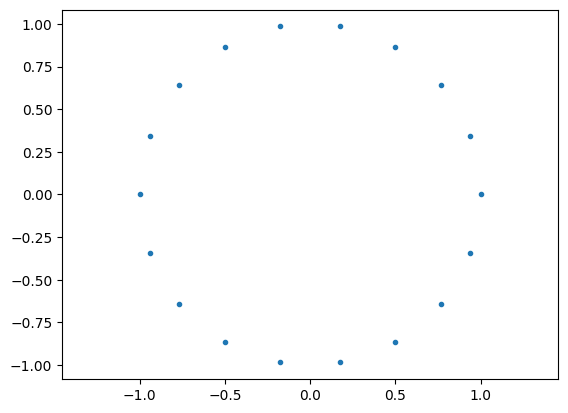

In [5]:
# define shape and plot
d = 2; n = 18 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape(root)

In [6]:
# diffusion and covariance specification for shape processes
# This version assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: params['k_alpha']*jnp.exp(-.5/params['k_sigma']*jnp.sum(jnp.square(x),2))

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
#sigma = lambda q,theta: kQ12_q(root,root,theta) # debug, constant covariance
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance
# multiply on the factorized matrix, e.g. covariance matrix
dot = lambda A,v: jnp.einsum('ij,jd->id',A,v.reshape((n,d))).flatten()
# multiple on inverse factorized matrix, e.g. inverse covariance matrix
solve = lambda A,v: jnp.linalg.solve(A,v.reshape((n,d))).flatten()

# Gaussian tree, node-dependent covariance

First, we initialize the tree. We set the root to the shape defined above.

In [7]:
# create tree and initialize with noise
tree = hyperiax.tree.builders.symmetric_tree(1,10)
print('Tree:',tree)

# set edge lengths on all nodes
edge_length = 1.
tree['edge_length'] = edge_length

# data dimension
d = 2

# root value
tree.root['value'] = root

Tree: HypTree with 2 levels and 11 nodes


We then define parameters for the Gaussian transition kernel.

In [8]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is sqare of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [9]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        return {'value': parent_value+jnp.sqrt(var)*dot(sigma(parent_value,params),noise)}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = LevelwiseTreeExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [10]:
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (n*d,))
dtree = down_unconditional.down(noise_tree,params.values())

Add uncorrelated observation noise to leaves.



In [11]:
# copy the sampled tree and add noise to leaf nodes
leaf_tree = dtree.copy()
for node in leaf_tree.iter_leaves():
    key, subkey = split(key)
    node['value'] += jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,node['value'].shape) # add observation noise

Plot a generated tree.

Text(0.5, 1.0, 'Sampled tree without leaf noise')

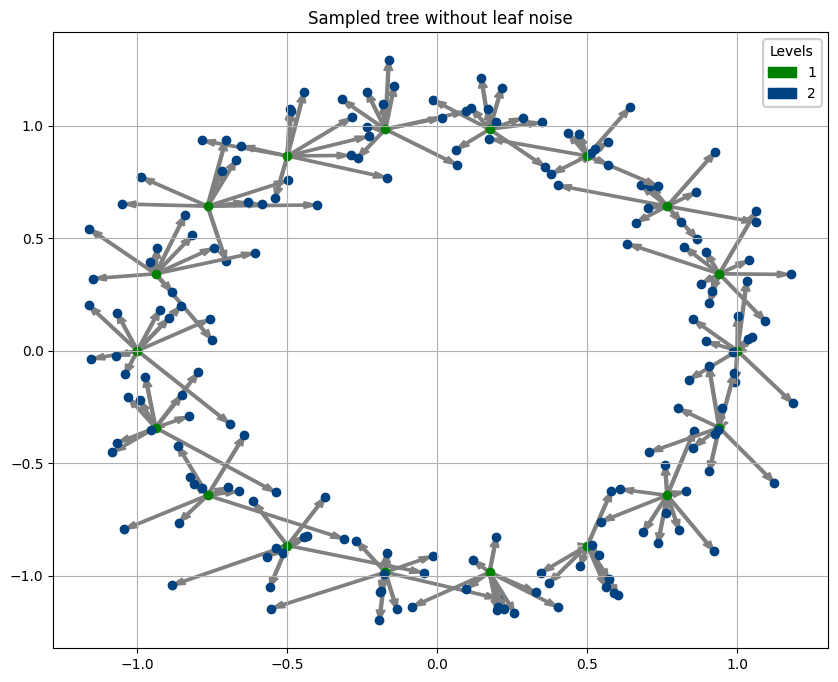

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
for i in range(n):
    dtree.plot_tree_2d(selector=lambda z: z['value'].reshape((n,d))[i],ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')



# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [13]:
# functions for pullback and likelihood ratios, see https://arxiv.org/abs/2203.04155 section 6.1 for details
quadratic = lambda x,H: jnp.dot(x,jnp.dot(H,x))
logphi = lambda x,mu,Sigma: jax.scipy.stats.multivariate_normal.logpdf(x,mu,Sigma) # log Gaussian density given precision matrix H
phi = lambda x,mu,Sigma: jax.scipy.stats.multivariate_normal.pdf(x,mu,Sigma) # Gaussian density in standard form
omega = lambda Sigma: (jnp.linalg.det(Sigma)*(2*jnp.pi)**Sigma.shape[0])**(-.5) # normalization constant for Gaussian
omega_H = lambda H: jnp.sqrt(jnp.linalg.det(H)/((2*jnp.pi)**H.shape[0])) # normalization constant for Gaussian
logomega = lambda Sigma: .5*(-jnp.linalg.slogdet(Sigma)[1]-jnp.log(2*jnp.pi)*Sigma.shape[0]) # log normalization constant for Gaussian
logomega_H = lambda H: .5*(jnp.linalg.slogdet(H)[1]-jnp.log(2*jnp.pi)*H.shape[0]) # log normalization constant for Gaussian
logphi_H = lambda x,mu,H:  logomega_H(H)-.5*quadratic(x-mu,H) # log Gaussian density in standard form
phi_H = lambda x,mu,H: jnp.exp(logphi_H(x,mu,H))
#logphi_can = lambda y,F,H: logomega_H(H)-.5*jnp.dot(F,jnp.solve(H,F))-.5*jnp.einsum('i,ij,j->',y,H,y)+jnp.dot(F,y) # Gaussian density in canonical form with normalization
logphi_can = lambda y,F,H: logphi_H(y,jnp.linalg.solve(H,F),H)
phi_can = lambda y,F,H: jnp.exp(logphi_can(y,F,H))
logU = lambda y,c,F,H: c-.5*quadratic(y,H)+jnp.dot(F,y) # unnormalized Gaussian density in canonical form
U = lambda y,c,F,H: jnp.exp(logU(y,c,F,H))

# debug
## only quadratic terms
#_logphi = lambda x,mu,Sigma: -.5*jnp.dot(x,jnp.linalg.solve(Sigma,(x)))
#_logU = lambda y,c,F,H: -.5*quadratic(y,H) # unnormalized Gaussian density in canonical form
## only linear terms
#_logphi = lambda x,mu,Sigma: jnp.dot(mu,jnp.linalg.solve(Sigma,(x)))
#_logU = lambda y,c,F,H: jnp.dot(y,F) # unnormalized Gaussian density in canonical form
## only constant terms
#_logphi = lambda x,mu,Sigma: logomega(Sigma)-.5*jnp.dot(mu,jnp.linalg.solve(Sigma,mu))
#_logU = lambda y,c,F,H: c # unnormalized Gaussian density in canonical form

# test
_Sigma = jnp.array([[1.,.5],[.5,1.]])
_H = jnp.linalg.inv(_Sigma)
_mu = jnp.array([2.,-7.])
_x = jnp.array([1.,1.])
print(logphi(_x,_mu,_Sigma),phi(_x,_mu,_Sigma))
print(logphi_H(_x,_mu,_H),phi_H(_x,_mu,_H))
print(logphi_can(_x,jnp.dot(_H,_mu),_H),phi_can(_x,jnp.dot(_H,_mu),_H))
print(logU(_x,logomega_H(_H)-.5*quadratic(_mu,_H),jnp.dot(_H,_mu),_H),U(_x,logomega_H(_H)-.5*quadratic(_mu,_H),jnp.dot(_H,_mu),_H))
print(logU(_x,logomega(_Sigma)-.5*quadratic(_mu,_H),jnp.dot(_H,_mu),_H),U(_x,logomega(_Sigma)-.5*quadratic(_mu,_H),jnp.dot(_H,_mu),_H))



-50.360703 1.3446981e-22
-50.360703 1.3446981e-22
-50.360703 1.3446981e-22
-50.360703 1.3446981e-22
-50.360703 1.3446981e-22


In [14]:
# backwards filter
@jax.jit
def up(noise,edge_length,c_T,F_T,H_T,params,**args):
    def f(edge_length,c_T,F_T,H_T):
        var = edge_length # variance is edge length

        Sigma_T = jnp.linalg.inv(H_T) # alt. Q_T
        v_T = dot(Sigma_T,F_T)
        covar = var*a(v_T,params) # covariance matrix
    
        invPhi_0 = (jnp.eye(n)+H_T@covar)
        Sigma_0 = Sigma_T@invPhi_0 # = Sigma_T+covar, alt. C_0
        H_0 = jnp.linalg.inv(Sigma_0) # hat H
        F_0 = solve(invPhi_0,F_T) # hat F
        v_0 = dot(Sigma_0,F_0)
        c_0 = c_T+jax.vmap(
            #lambda v_0,F_T: logphi(v_0,jnp.zeros(n),Sigma_0),
            #lambda v_0: logphi(jnp.zeros(n),v_0,Sigma_0),
            #1)(v_0.reshape((n,d)))
            lambda v_T,F_T: -logphi_can(jnp.zeros(n),F_T,H_T)+logphi(jnp.zeros(n),v_T,Sigma_0),
            (1,1))(v_T.reshape((n,d)),F_T.reshape((n,d)))

        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,c_T,F_T,H_T)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [15]:
# initialize tree for up
def init_up(tree,params):
    for node in tree.iter_bfs():
        if node.children and node.parent:
            del node.data['value']
        else:
            v = node['value']
            Sigma = params['obs_var'].value*jnp.eye(n)
            H = jnp.eye(n)/params['obs_var'].value
            #var = edge_length # variance is edge length
            #Sigma = var*a(root,params.values()) # test covariance matrix
            #H = jnp.linalg.inv(Sigma) # test precision matrix
            F = dot(H,v)
            c = jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d)))
            node.data = {**node.data, 'c_T': c, 'F_T': F, 'H_T': H}

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [16]:
@jax.jit
def down_conditional(noise,edge_length,up_msg,F_T,H_T,parent_value,params,**args):
    def f(noise,edge_length,c_0,F_0,H_0,F_T,H_T,parent_value):
        x = parent_value
        var = edge_length # variance is edge length
        covar = var*a(parent_value,params) # covariance matrix

        invSigma = jnp.linalg.inv(covar)
        H = H_T+invSigma
        mu = solve(H,F_T+dot(invSigma,x))

        # for likelihood ratio
        Sigma_T = jnp.linalg.inv(H_T)
        v_T = dot(Sigma_T,F_T) # solve(H_T,F_T)

        # test
        Sigma_0 = jnp.linalg.inv(H_0)
        v_0 = dot(Sigma_0,F_0)

        return {
            'value': mu+jax.scipy.linalg.solve_triangular(jax.scipy.linalg.cholesky(H,lower=True),noise.reshape((n,d))).flatten(),
            'logw': jnp.sum(jax.vmap(
                lambda v_T,parent_value,c_0,F_0: logphi(v_T,parent_value,covar+Sigma_T)-logU(parent_value,c_0,F_0,H_0),
                (1,1,0,1))(v_T.reshape((n,d)),parent_value.reshape((n,d)),c_0.reshape(d),F_0.reshape((n,d)))),
            #'test': jnp.sum(jax.vmap(
            #    lambda v_T,parent_value,c_0,F_0: _logphi(parent_value,v_T,covar+Sigma_T)-_logU(parent_value,c_0,F_0,H_0)
            #    ,(1,1,0,1))(v_T.reshape((n,d)),parent_value.reshape((n,d)),c_0.reshape(d),F_0.reshape((n,d)))),
            }

    return jax.vmap(f)(noise,edge_length,up_msg['c_0'],up_msg['F_0'],up_msg['H_0'],F_T,H_T,parent_value)



We create the model and executor for the backwards filter (up) and forwards guiding (down).

In [17]:
# create model and executor
fuse = lambda child_c_0,child_F_0,child_H_0,**kwargs: {'c_T': jnp.sum(child_c_0,0), 'F_T': jnp.sum(child_F_0,0), 'H_T': jnp.sum(child_H_0,0)} # sum over the last axis, time 0 for child edges is time T for the fusing node
updownmodel = UpDownLambda(up_fn=up,fuse_fn=sum_fuse_children(axis=0),down_fn=down_conditional)
updown = LevelwiseTreeExecutor(updownmodel)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [18]:
# backwards filter and fowards guiding
utree = leaf_tree.copy()
init_up(utree,params)
utree = updown.up(utree,params.values())
utree.root['value'] = root
dtree_conditional = updown.down(utree,params.values())

# time the operations
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (n*d,))
%time down_unconditional.down(noise_tree,params.values())
%time updown.up(utree,params.values())
updown.up(utree,params.values())
%time updown.up(utree,params.values())

# test
print([node['logw'] for node in dtree_conditional.iter_bfs() if node.parent])
#print([node['test'] for node in dtree_conditional.iter_bfs() if node.parent])
print([node for node in dtree_conditional.iter_bfs() if node.parent])



CPU times: user 1.57 ms, sys: 1 µs, total: 1.57 ms
Wall time: 1.57 ms
CPU times: user 5.15 ms, sys: 35 µs, total: 5.19 ms
Wall time: 5.2 ms
CPU times: user 4.95 ms, sys: 4 µs, total: 4.95 ms
Wall time: 4.98 ms
[Array(22.797152, dtype=float32), Array(1.421133, dtype=float32), Array(0.32501984, dtype=float32), Array(2.763832, dtype=float32), Array(1.2244358, dtype=float32), Array(5.9766483, dtype=float32), Array(1.277401, dtype=float32), Array(0.41768837, dtype=float32), Array(-0.13536072, dtype=float32), Array(-0.02266312, dtype=float32)]
[TreeNode({'edge_length': 1.0, 'noise': Array([ 0.6261994 ,  0.93188107, -2.9715116 ,  0.18650463, -0.16800588,
        0.6322332 , -1.1303608 , -0.5686714 , -1.9412435 , -0.24328563,
        1.0634123 ,  1.9505794 ,  0.7026265 ,  0.4826952 ,  1.9927517 ,
       -0.26964584, -0.11632834, -0.1632461 ,  0.48121682,  0.49963564,
       -0.3509555 ,  1.9573301 , -0.475333  , -0.8790985 , -0.66189605,
        1.5635828 ,  0.3754038 ,  0.4164519 , -1.0255184

# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.125, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.1, 'k_sigma': 0.25, 'obs_var': 0.001}


100%|██████████| 400/400 [00:19<00:00, 20.65it/s]


Acceptance rate: 0.6525


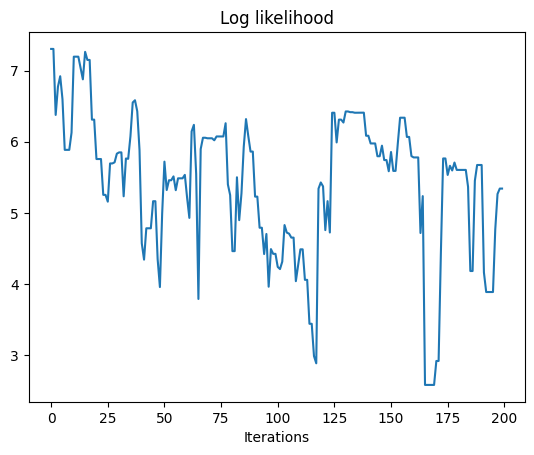

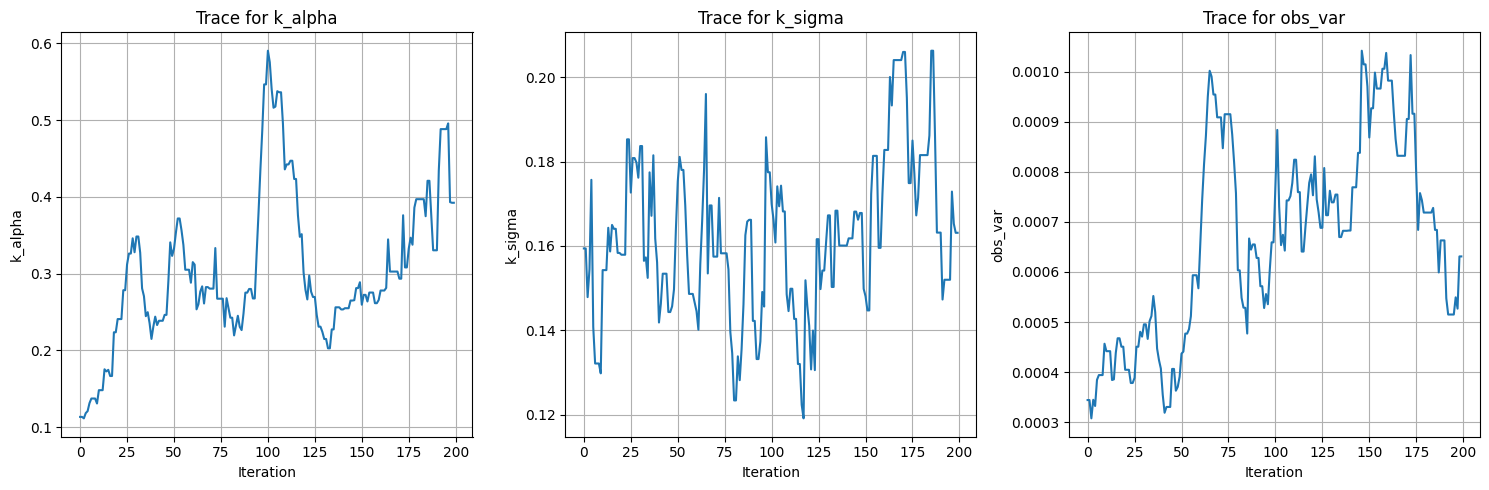

In [19]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = lambda node: .9
update_CN = lambda tree,key: update_noise_inplace(lambda node,new: node['noise']*lambd(node)+jnp.sqrt((1-lambd(node)**2))*new,tree,key)
zero_noise = lambda tree,key: update_noise_inplace(lambda node,new: jnp.zeros_like(node['noise']),tree,key)

# downwards pass to compute likelihoods
#@jax.jit
def down_log_likelihood(noise,value,edge_length,parent_value,logw,params,**args):
    var = edge_length # variance is edge length
    return {'log_likelihood': jnp.mean(
        jax.vmap(lambda v,m,var,logw: logw+jax.scipy.stats.norm.logpdf(
            jax.vmap(lambda w: jnp.linalg.solve(sigma(m,params)/params['k_alpha'],w),1)((v-m).reshape((n,d))).flatten(),
            0,jnp.sqrt(var)*params['k_alpha']))(value,parent_value,var,logw)
        ,1)
        }
downmodel_log_likelihood = DownLambda(down_fn=down_log_likelihood)
down_log_likelihood = LevelwiseTreeExecutor(downmodel_log_likelihood,batch_size=100)

# log likelihood of the tree
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,tree = state
    log_likelihood_tree = down_log_likelihood.down(tree,params.values())
    log_likelihood_tree.root['log_likelihood'] = 0
    tree_log_likelihood = jnp.mean(jnp.array([node['log_likelihood'] for node in log_likelihood_tree.iter_bfs()]))
    residuals = jnp.array([sample['value']-obs['value'] for sample,obs in zip(tree.iter_leaves(),data.iter_leaves())]) 
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,tree = state

    # new tree with the leaf data
    utree = tree.copy(); 
    for data_leaf,utree_leaf in zip(data.iter_leaves(),utree.iter_leaves()):
        utree_leaf['value'] = data_leaf['value']

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # backwards filtering with updated parameters
    init_up(utree,new_parameters)
    utree = updown.up(utree,new_parameters.values())

    # update tree, CN update and forward filtering with the updated noise
    utree_CN = update_CN(utree,subkeys[1])
    dtree = updown.down(utree_CN,new_parameters.values())

    return new_parameters,dtree

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.125), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance. We keep it constant here because of lacking identifiability (which will not be the case with higher-dimensional correlated data)
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
leaf_tree.root['value'] = root
leaf_tree = zero_noise(leaf_tree,key)
utree = leaf_tree.copy(); init_up(utree,init_params);
init_state = (init_params,updown.down(updown.up(utree,init_params.values()),init_params.values()))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_tree, init_state, 200, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)